In [1]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import output_functions as of
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import lin_prog_functions as lpf


In [2]:
#grid_file_path = 'Outputs/Logs/grid_variables{}.csv'.format(run)
journeys = pickle.load(open('Outputs/journeys_range','rb'))
eprice = pickle.load(open('Outputs/price_data','rb'))
empty_profile = pickle.load(open('Outputs/empty_profile','rb'))

Run: 75 / Charger: 22 / Capacity: 30
opt status: Optimal
Cost: 1779.699680252
BAU status: Optimal
Cost: 361914.73821359
BAU2 status: Optimal
Cost: 362341.03539416
2019-03-05 Status: 3 : 1 1 1
opt status: Infeasible
opt Partial charge status: Optimal
Cost: 265.99999997
BAU status: Optimal
Cost: 490836.26377321
BAU2 status: Infeasible
BAU2 Partial charge status: Optimal
Cost: 266.00000001
2019-03-06 Status: -1 : -1 1 -1
opt status: Optimal
Cost: 2271.1537022485995
BAU status: Optimal
Cost: 425330.9046796
BAU2 status: Optimal
Cost: 472456.71978821995
2019-03-07 Status: 3 : 1 1 1
opt status: Infeasible
opt Partial charge status: Optimal
Cost: 240.0
BAU status: Optimal
Cost: 524453.3180874999
BAU2 status: Infeasible
BAU2 Partial charge status: Optimal
Cost: 240.00000003
2019-03-08 Status: -1 : -1 1 -1
opt status: Infeasible
opt Partial charge status: Infeasible
Magic!!
BAU status: Optimal
Cost: 530431.43446738
BAU2 status: Infeasible
BAU2 Partial charge status: Infeasible
Magic!!
2019-03-09

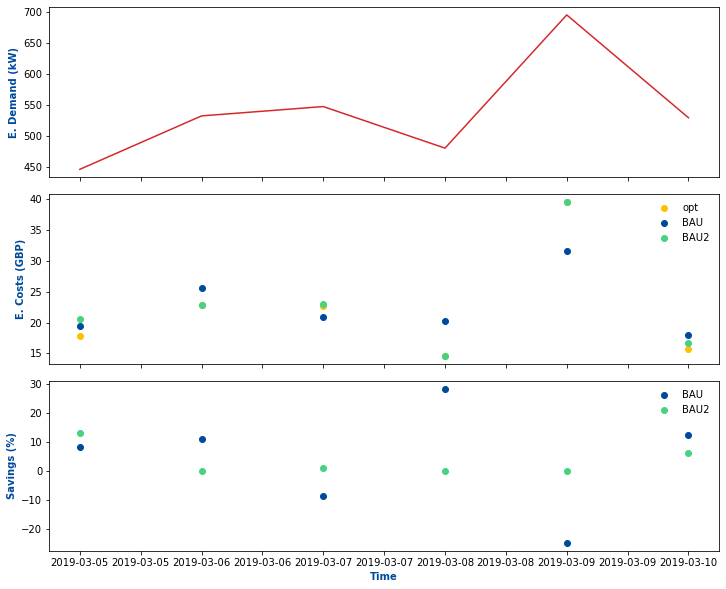

In [5]:
## Range Test

run = 75
charger = 22
capacity = 30
ca='opt'
notes = 'Introduced a magic charging step when completely unfeasible'
site_capacity = {
    'opt': capacity,  
    'BAU': 10000,
    'BAU2': capacity
}
script_strt = time.process_time()
print('Run:',run,'/ Charger:',charger,'/ Capacity:',capacity)
os.makedirs('Outputs/Logs/run{}'.format(run))

profile_out, dates, bad_days, lpprob = lpf.optimise_range2(
    empty_profile, 
    charger, 
    site_capacity)

range_profile, site_profile, days_summary, global_summary = of.summary_outputs(
profile_out, 
    journeys, 
    dates)

os.makedirs('Outputs/Logs/run{}/daily'.format(run))
for date in dates:
    day = dt.datetime.combine(date, dt.datetime.min.time())
    day_profile = of.create_daily_summary(site_profile, day)
    fig_summary = of.summary_plot(day_profile)
    fig_summary.savefig(
        'Outputs/Logs/run{}/daily/fig{}.jpg'.format(run,date))
    plt.close(fig_summary)

with open('Outputs/Logs/run{}/variables{}.csv'.format(run,run),'a') as fi:
    fi.write(notes)
    fi.write('\n' + str(run)+'\n'+str(charger) + '\n' + str(capacity) +'\n')
    fi.write(global_summary.to_string())
    fi.write(bad_days)

range_fig = of.daily_summary_plot(days_summary.fillna(0))
range_fig.savefig(
            'Outputs/Logs/run{}/fig_range{}.svg'.format(run,run),
            bbox_inches = "tight")
range_fig.show()

In [7]:
## Single Day test

day = dt.datetime(2019,3,8)
day_profile = f.create_daily_schedule(empty_profile, day)

initial_rel_charge = pd.Series(
        data = [0,0,0,-20,0],
        index = empty_profile.index.get_level_values(1).unique()
    )

output_df, PuLP_prob, fsoc = lpf.linear_optimiser_V3(
                    day_profile,
                    ca,
                    charger,
                    site_capacity,
                    initial_rel_charge
                    )

day_profile_out = day_profile.merge(
                output_df,
                how='left',
                left_index=True,
                right_index=True,
                )
range_profile = day_profile_out.fillna(0)
cols=gv.CAT_COLS
vehicles = output_df.index.get_level_values(1).unique()

range_profile[cols['CHARGE_DEL'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * gv.CHARGER_EFF)
range_profile[cols['ECOST'][ca]] = (
    range_profile[cols['OUTPUT'][ca]] 
    * range_profile[cols['PRICE']['opt']])
for vehicle in vehicles:
    range_profile.loc[(slice(None),vehicle),cols['SOC'][ca]] = (
        gv.BATTERY_CAPACITY + initial_rel_charge
        + range_profile.loc[(slice(None),vehicle),cols['CHARGE_DEL'][ca]].cumsum() 
        + range_profile.loc[(slice(None),vehicle),'Battery_Use'].cumsum()
        )*100/gv.BATTERY_CAPACITY

opt status: Infeasible
opt Partial charge status: Infeasible
Magic!!


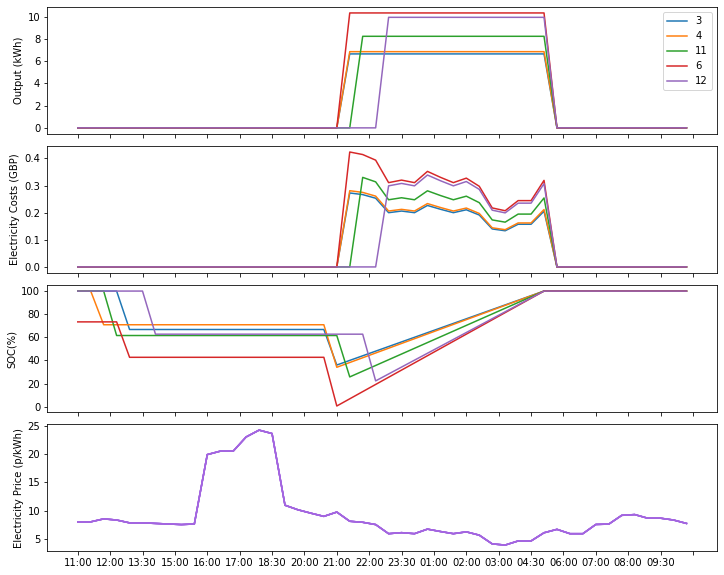

In [8]:
fig, axs = plt.subplots(
    4,
    figsize=(12,10),
    sharex=True, 
    gridspec_kw={'hspace':0.1})

x = range_profile.unstack().index.strftime('%H:%M')
cols = gv.CAT_COLS

axs[0].plot(
    x, 
    range_profile.unstack()[cols['OUTPUT'][ca]]*2)
axs[0].legend(list(vehicles))
axs[0].set_ylabel('Output (kWh)')

axs[1].plot(
    x, 
    range_profile.unstack()[cols['ECOST'][ca]]/100)
axs[1].set_ylabel('Electricity Costs (GBP)')

axs[2].plot(
    x, 
    range_profile.unstack()[cols['SOC'][ca]])
axs[2].set_ylabel('SOC(%)')

axs[3].plot(
    x, 
    range_profile.unstack()[cols['PRICE']['opt']], 
    color=gv.FPS_PURPLE)
axs[3].set_ylabel('Electricity Price (p/kWh)')
for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()